# Computer Vision Task 2

## Step 1: Dataset Preprocessing

###### Dataswt is organized in many folders each contain related emotion images

In [1]:
import os
import cv2
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def load_data(data_folder_path):
    labels = []
    image_paths = []
    label_map = {}
    current_label = 0

    for person_name in os.listdir(data_folder_path):
        person_path = os.path.join(data_folder_path, person_name)
        if not os.path.isdir(person_path):
            continue

        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            image_paths.append(image_path)
            labels.append(current_label)

        label_map[current_label] = person_name
        current_label += 1

    return image_paths, labels, label_map

# Path to your dataset
data_folder_path = "Dataset"
image_paths, labels, label_map = load_data(data_folder_path)

# Split the dataset into training and testing
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets
train_dataset = FaceDataset(train_paths, train_labels, transform=transform)
test_dataset = FaceDataset(test_paths, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Define the CNN Model

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class FaceNet(nn.Module):
    def __init__(self, num_classes):
        super(FaceNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 24 * 24, 500)  # Adjust the input size for the fully connected layer
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        
        x = x.view(-1, 64 * 24 * 24)  # Adjust the view size based on the actual size
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Assuming input size is (3, 48, 48)
num_classes = len(label_map)
model = FaceNet(num_classes)

## Step 3: Train the Model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}')

print('Finished Training')


Epoch 1/10, Loss: 9.969027191400528
Epoch 2/10, Loss: 2.2400386730829873
Epoch 3/10, Loss: 1.7904335657755535
Epoch 4/10, Loss: 1.6967956026395161
Epoch 5/10, Loss: 1.6431482930978139
Epoch 6/10, Loss: 1.6079142391681671
Epoch 7/10, Loss: 1.57981343070666
Epoch 8/10, Loss: 1.539437045653661
Epoch 9/10, Loss: 1.507846216360728
Epoch 10/10, Loss: 1.4759639998277028
Finished Training


Epoch 1/50, Loss: 2.039973735809326
Epoch 2/50, Loss: 1.6727536022663116
Epoch 3/50, Loss: 1.5688513219356537
Epoch 4/50, Loss: 1.4807440141836803
Epoch 5/50, Loss: 1.4121123651663463
Epoch 6/50, Loss: 1.343207488457362
Epoch 7/50, Loss: 1.2772092322508495
Epoch 8/50, Loss: 1.224999725818634
Epoch 9/50, Loss: 1.1628705561161041
Epoch 10/50, Loss: 1.1367699106534321
Epoch 11/50, Loss: 1.061029851436615
Epoch 12/50, Loss: 1.0072717567284901
Epoch 13/50, Loss: 0.9528310596942902
Epoch 14/50, Loss: 0.924012025197347
Epoch 15/50, Loss: 0.873199055592219
Epoch 16/50, Loss: 0.8477152486642202
Epoch 17/50, Loss: 0.7952977766593298
Epoch 18/50, Loss: 0.7728614211082458
Epoch 19/50, Loss: 0.7046724408864975
Epoch 20/50, Loss: 0.6716871758302053
Epoch 21/50, Loss: 0.6398118883371353
Epoch 22/50, Loss: 0.6104583839575449
Epoch 23/50, Loss: 0.5576526001095772
Epoch 24/50, Loss: 0.5201660518844923
Epoch 25/50, Loss: 0.4884759734074275
Epoch 26/50, Loss: 0.4724386657277743
Epoch 27/50, Loss: 0.426762

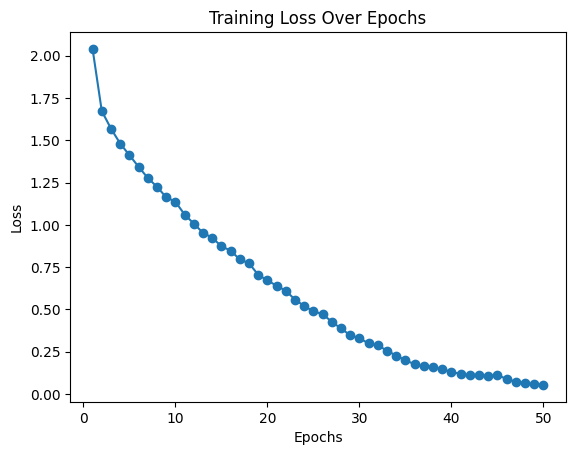

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
losses = []  # List to store losses over epochs

for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize loss for the current epoch
    for i, (inputs, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    average_epoch_loss = epoch_loss / len(train_loader)
    losses.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_epoch_loss}')

# Plotting the loss curve
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Save the Model

In [ ]:
# Save only the model's state dictionary
torch.save(model.state_dict(), 'emotion_model1.pth')

In [7]:
import torch
# Save the entire model
torch.save(model, 'emotion_model.pth')

# Save the label map
torch.save(label_map, 'emotion_label_map.pth')


#### Load the Model

In [8]:
# Load the model
model = torch.load('emotion_model.pth')
model.eval()

# Load the label map
label_map = torch.load('emotion_label_map.pth')

## Step 4: Real-Time Emotion Recognition

In [16]:
import torch
# Load the model
model = torch.load('emotion_model.pth')
model.eval()

# Load the label map
label_map = torch.load('emotion_label_map.pth')
# Function to preprocess input frame
def preprocess_frame(frame):
    # Resize, normalize and convert frame to tensor
    # Adjust this according to how you preprocessed images during training
    frame = cv2.resize(frame, (48, 48)) 
    frame = frame / 255.0
    frame = torch.Tensor(frame).permute(2, 0, 1).unsqueeze(0)
    return frame

# Webcam capture
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = preprocess_frame(face)

        output = model(face)
        _, predicted = torch.max(output, 1)
        label = label_map[int(predicted)]

        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

    cv2.imshow('Real-time Emotion Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


ColorFull Predictions

In [9]:
import cv2
import torch

# Function to preprocess input frame
def preprocess_frame(frame):
    # Resize, normalize and convert frame to tensor
    # Adjust this according to how you preprocessed images during training
    frame = cv2.resize(frame, (48, 48)) 
    frame = frame / 255.0
    frame = torch.Tensor(frame).permute(2, 0, 1).unsqueeze(0)
    return frame

# Webcam capture
cap = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Define color map for different labels
label_color_map = {
    "angry": (0, 0, 255),      # Red
    "disgust": (255, 0, 0),    # Blue
    "fear": (0, 255, 255),     # Yellow
    "happy": (0, 255, 0),      # Green
    "neutral": (255, 255, 0),  # Cyan
    "sad": (255, 165, 0),      # Orange
    "surprise": (255, 0, 255)  # Magenta
}

while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = preprocess_frame(face)

        output = model(face)
        _, predicted = torch.max(output, 1)
        label = label_map[int(predicted)]

        # Use the color map to get the color for the label
        color = label_color_map.get(label, (255, 255, 255))  # Default to white if label not found

        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    cv2.imshow('Real-time Emotion Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
